In [1]:
import pandas as pd
import re
import sys
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
df = pd.read_csv('Labelled Yelp Dataset.csv',encoding='latin1')
df.shape

(359052, 6)

In [3]:
df.head()

,User_id,Product_id,Rating,Date,Review,Label
0,923,0,3,12/8/2014,The food at snack is a selection of popular Gr...,-1
1,924,0,3,5/16/2013,This little place in Soho is wonderful. I had ...,-1
2,925,0,4,7/1/2013,ordered lunch for 15 from Snack last Friday. Ã...,-1
3,926,0,4,7/28/2011,This is a beautiful quaint little restaurant o...,-1
4,927,0,4,11/1/2010,Snack is great place for a ÃÂ casual sit down...,-1


In [27]:
df[df['Label']== -1][['User_id']].value_counts(ascending=False).head(15)

User_id
5415       48
6541       44
4157       40
923        39
17800      39
4199       35
4181       34
14386      33
4168       33
8980       31
931        31
23016      29
4137       29
3538       26
2587       26
dtype: int64

In [37]:
df[df['Label']== 1]['Label'].groupby(df['Rating']).agg('count')

Rating
1     10658
2     18383
3     44473
4    124502
5    124151
Name: Label, dtype: int64

In [32]:
df[df['Label']== -1]['Label'].groupby(df['Rating']).agg('count')

Rating
1     3566
2     2392
3     3173
4    10748
5    17006
Name: Label, dtype: int64

## EDA

In [11]:
statistics_of_data = []
for col in df[['User_id','Product_id','Rating','Date','Label']]:
    statistics_of_data.append((col,
                             len(df[col]),
                             100-df[col].isnull().sum()*100/df.shape[0],
                             df[col].nunique(),
                             df[col].value_counts().idxmax()
                             ))
stats_df = pd.DataFrame(statistics_of_data, columns=['Column Name', '# of Records', '% populated', 'Unique Values', 'Most Common Field Value'])
stats_df

,Column Name,# of Records,% populated,Unique Values,Most Common Field Value
0,User_id,359052,100.0,160225,3504
1,Product_id,359052,100.0,923,247
2,Rating,359052,100.0,5,5
3,Date,359052,100.0,3417,1/5/2015
4,Label,359052,100.0,2,1


In [14]:
### for reviews text
statistics_of_data = []
for col in df[['Review']]:
    statistics_of_data.append((col,
                             len(df[col]),
                             100-df[col].isnull().sum()*100/df.shape[0],
                             df[col].nunique()
                             ))
stats_df = pd.DataFrame(statistics_of_data, columns=['Column Name', '# of Records', '% populated', 'Unique Values'])
stats_df

,Column Name,# of Records,% populated,Unique Values
0,Review,359052,100.0,358156


In [15]:
#### We can see that these data is 100% populated and we do not need to deal with missing values

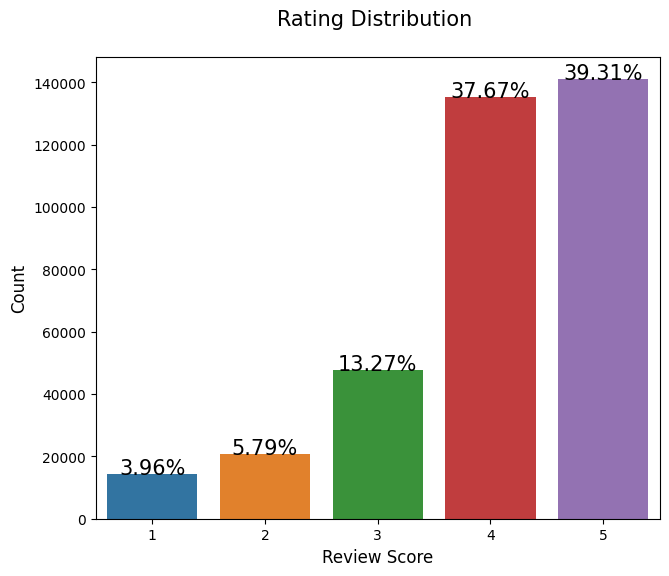

In [26]:
plt.figure(figsize=(16,6))
plt.subplot(121)
g = sns.countplot(x='Rating', data=df)
total = len(df)
g.set_title("Rating Distribution \n", fontsize=15)
g.set_xlabel("Review Score", fontsize=12)
g.set_ylabel('Count', fontsize=12)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 
plt.show()

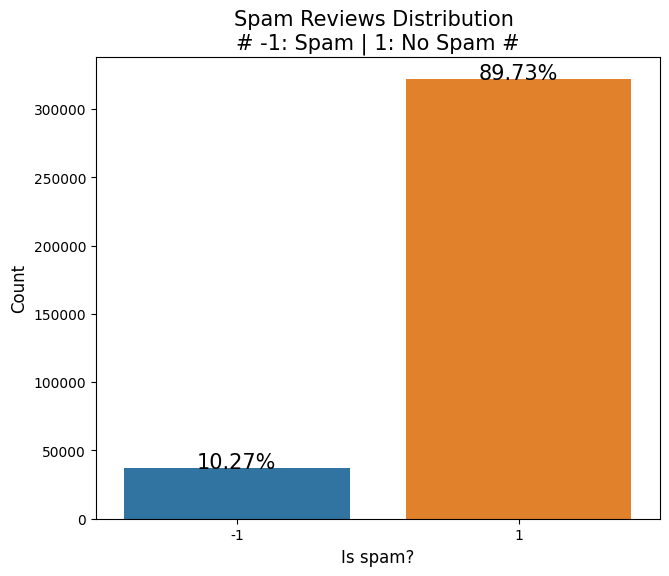

In [108]:
plt.figure(figsize=(16,6))
plt.subplot(121)
g = sns.countplot(x='Label', data=df)
total = len(df)
g.set_title("Spam Reviews Distribution \n# -1: Spam | 1: No Spam #", fontsize=15)
g.set_xlabel("Is spam?", fontsize=12)
g.set_ylabel('Count', fontsize=12)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 
plt.show()

In [56]:
df['Date'] = pd.to_datetime(df.Date)

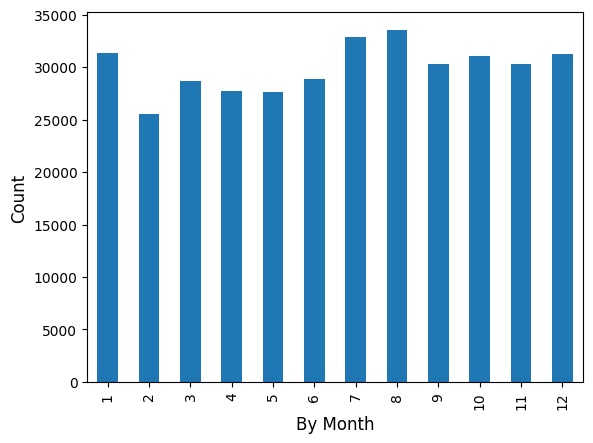

<Figure size 2000x1000 with 0 Axes>

In [60]:
#By month
df2 = df['Date'].groupby(df.Date.dt.month).agg('count')
g = df2.plot(kind='bar')
g.set_xlabel("By Month", fontsize=12)
g.set_ylabel('Count', fontsize=12)
plt.figure(figsize=(20,10))
plt.show()

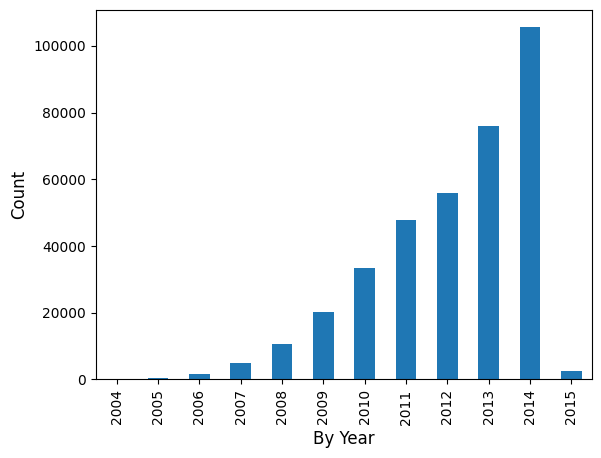

<Figure size 2000x1000 with 0 Axes>

In [109]:
#By year
df2 = df['Date'].groupby(df.Date.dt.year).agg('count')
g = df2.plot(kind='bar')
g.set_xlabel("By Year", fontsize=12)
g.set_ylabel('Count', fontsize=12)
plt.figure(figsize=(20,10))
plt.show()

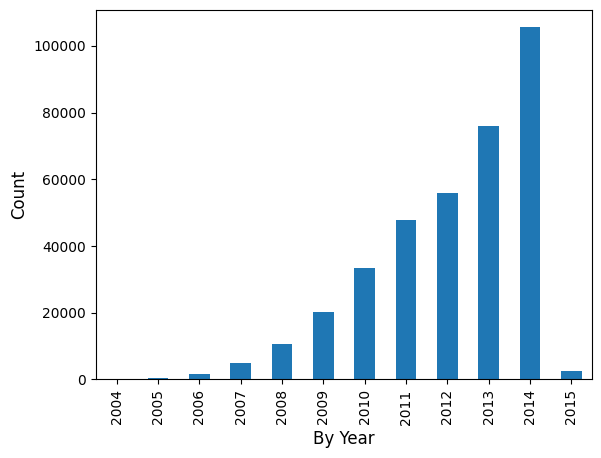

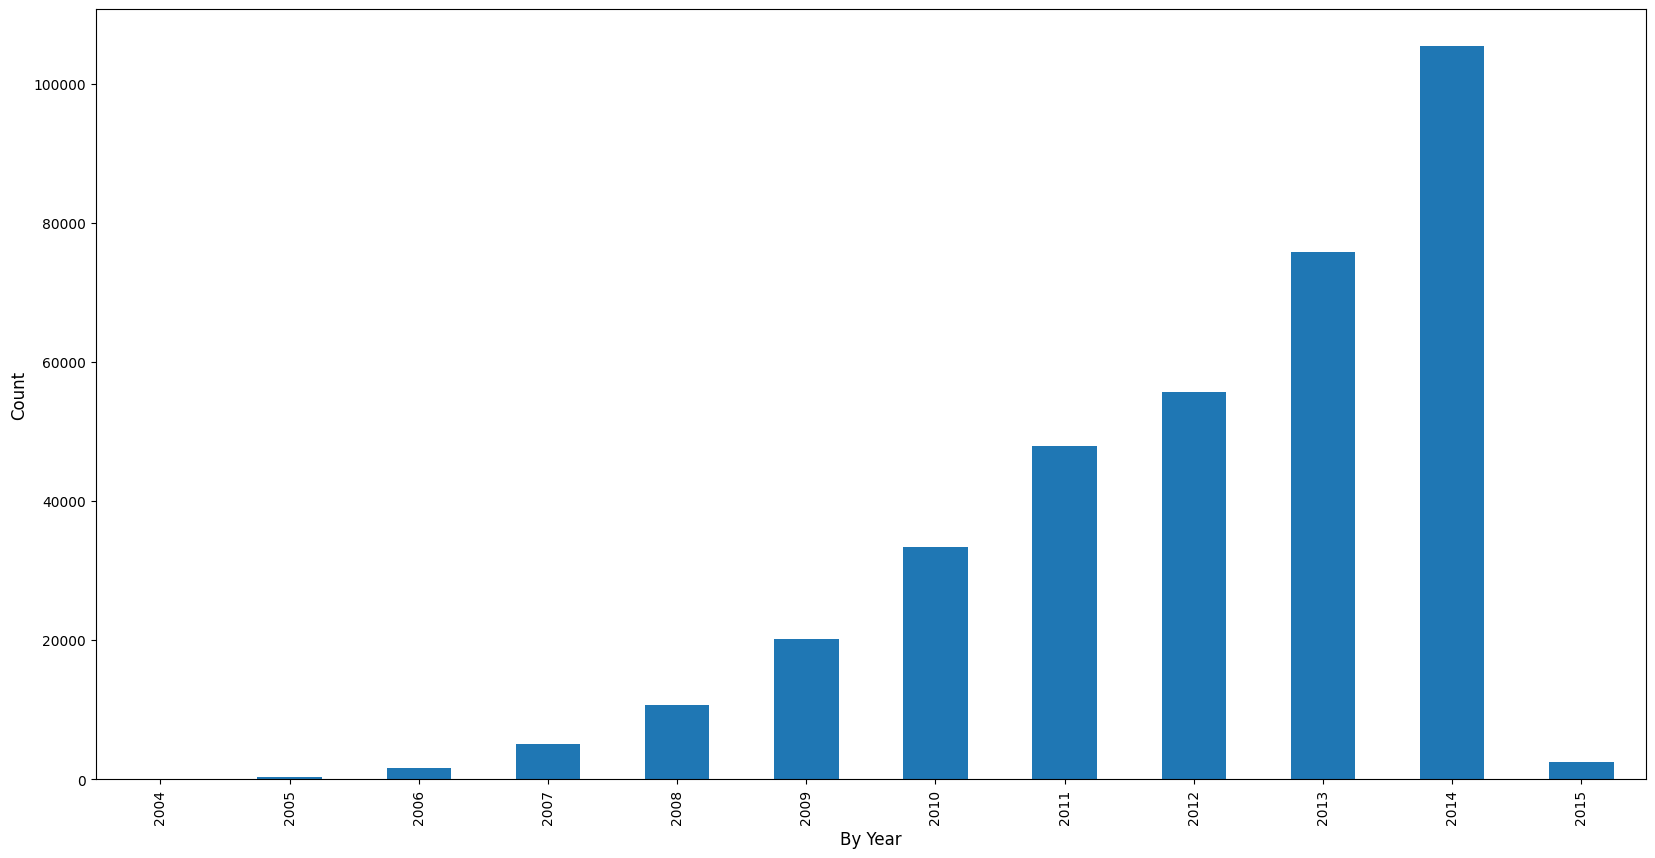

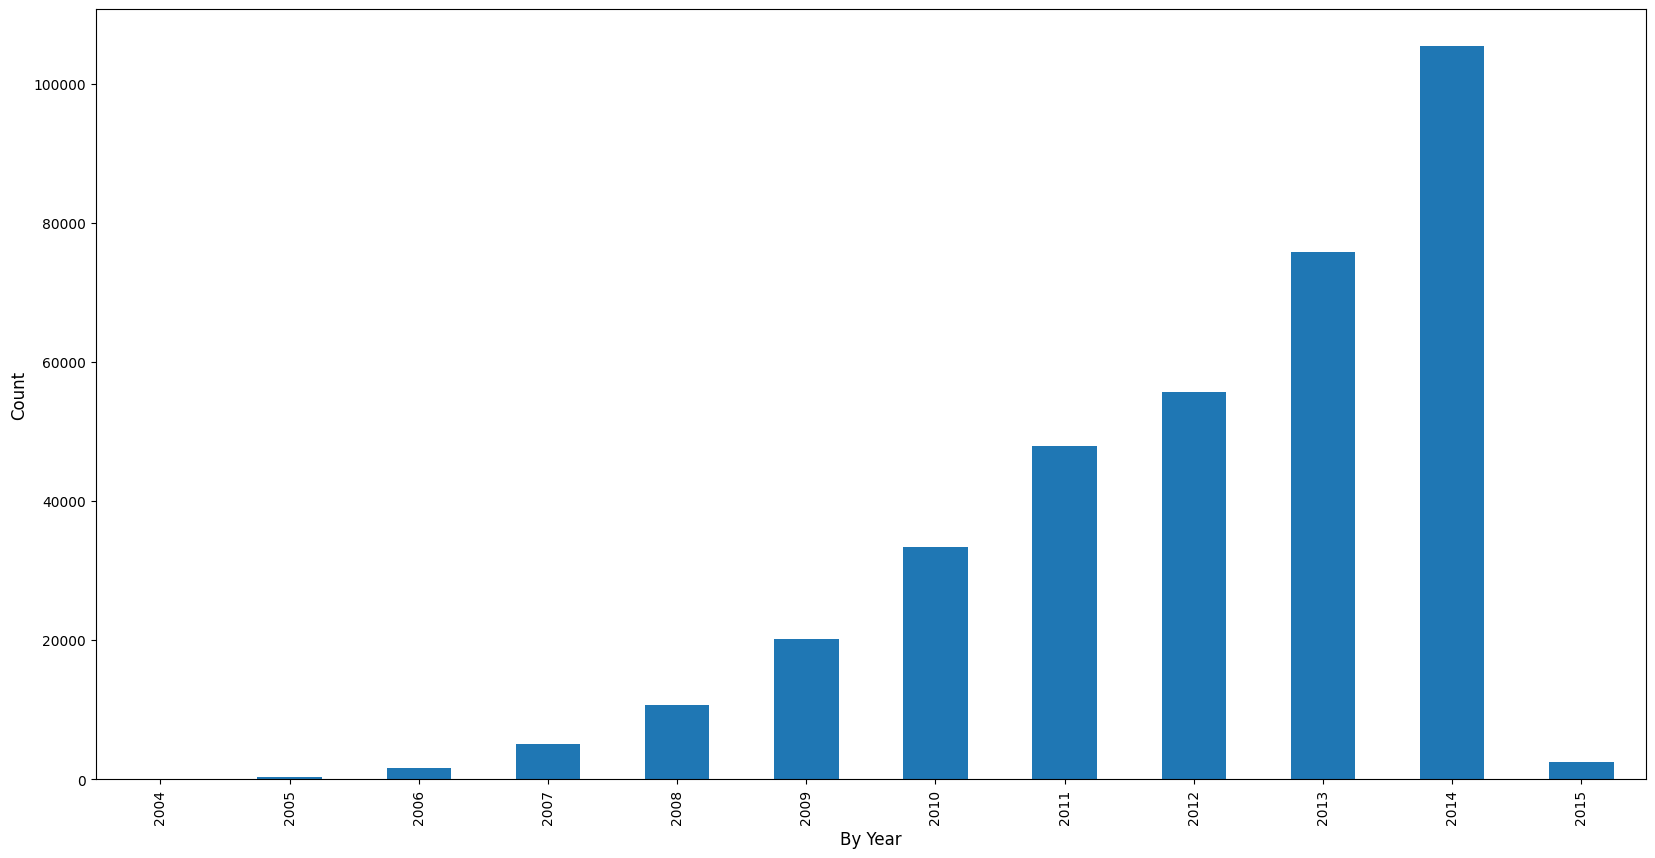

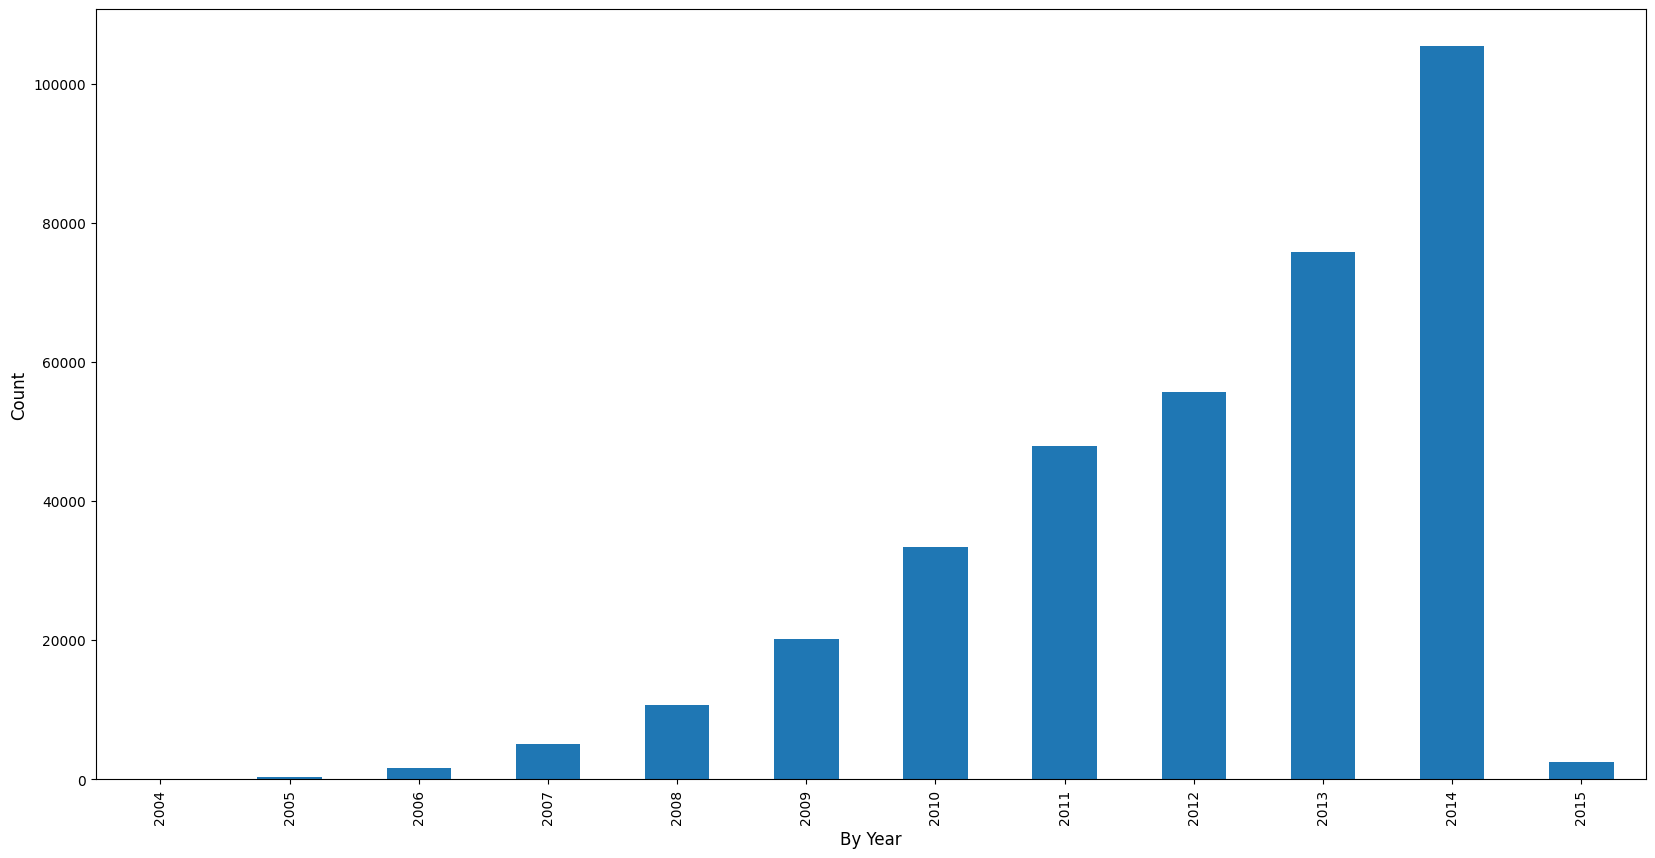

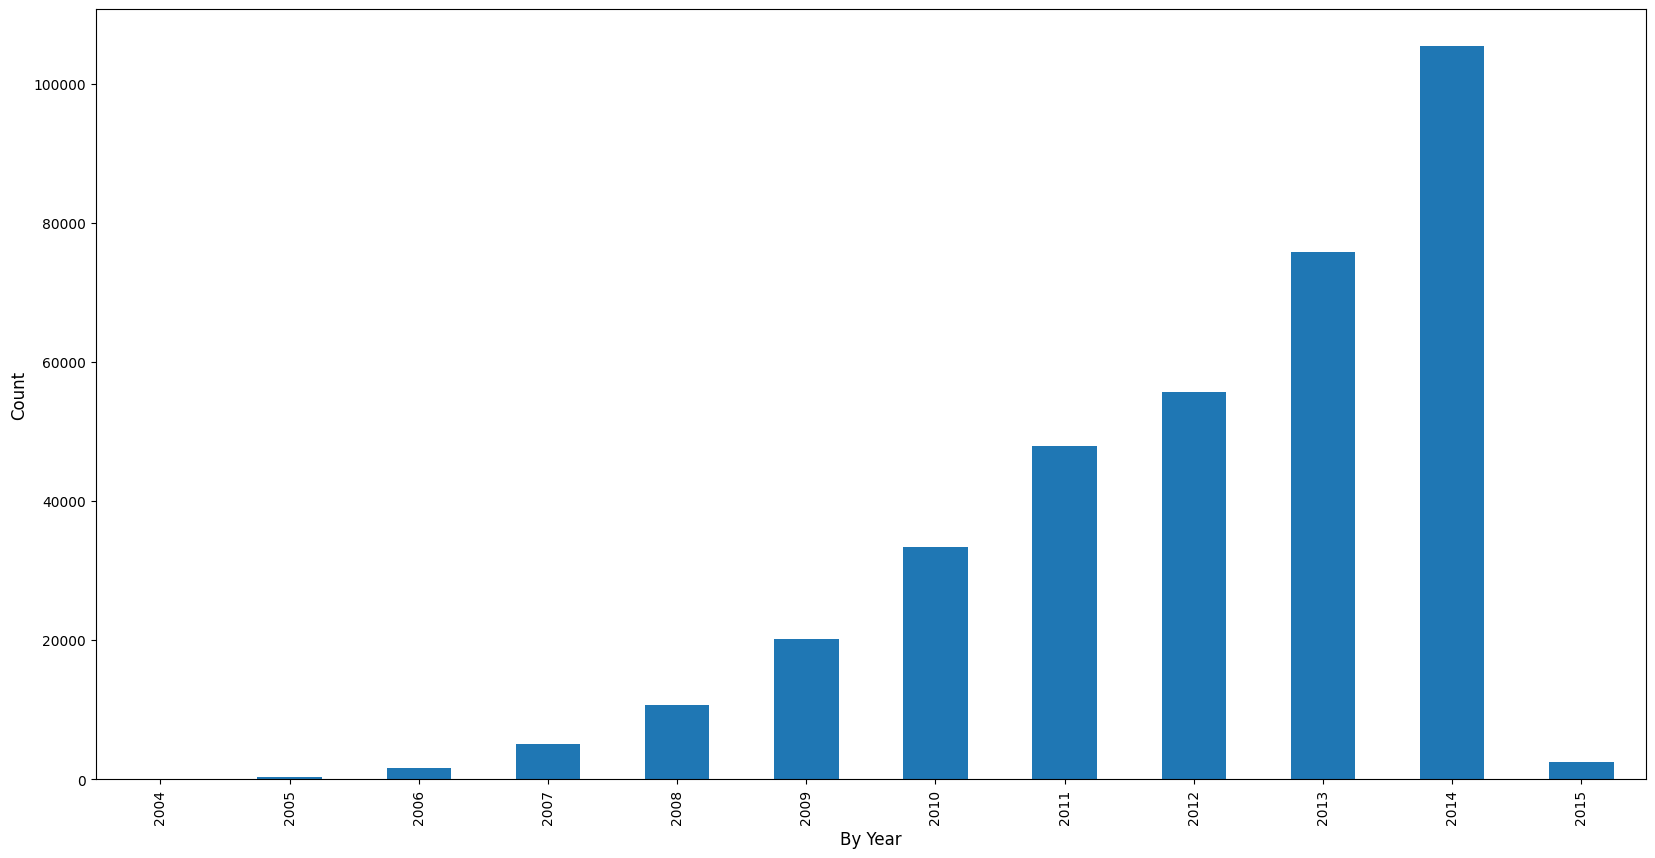

<Figure size 2000x1000 with 0 Axes>

In [13]:
#By year
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
df2 = df['User_id'].groupby(df.Date.dt.year).agg('count')
g = df2.plot(kind='bar')
g.set_xlabel("By Year", fontsize=12)
g.set_ylabel('Count', fontsize=12)
plt.figure(figsize=(20,10))
plt.show()

## Remove Stopwords and Regex and Lemmentazation

In [1]:
from textacy.preprocessing.replace import urls, hashtags, numbers, emails, emojis, currency_symbols
from textacy.preprocessing.normalize import quotation_marks, bullet_points
from textacy.preprocessing.remove import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from collections import Counter

In [63]:
df['Review'] = df['Review'].str.lower()

In [113]:
#remove all digits
df['Review'] = df['Review'].str.replace('\d+', '')

In [114]:
df['Review'].head()

0    the food at snack is a selection of popular gr...
1    this little place in soho is wonderful. i had ...
2    ordered lunch for  from snack last friday. ãâ...
3    this is a beautiful quaint little restaurant o...
4    snack is great place for a ãâ casual sit down...
Name: Review, dtype: object

In [ ]:
# remove all urls, hashtags,numbers,currency_symbols, emojis, emails and punctuation
df["Review_cleaned"] = df['Review'].\
  apply(urls).\
  apply(hashtags).\
  apply(numbers).\
  apply(currency_symbols).\
  apply(emojis).\
  apply(emails).\
  apply(punctuation)

In [ ]:
df['Review_cleaned'].head()

In [91]:
# remove stopwords
stopwords = set(nltk.corpus.stopwords.words('english'))
df['Review_no_stopwords'] = df['Review_cleaned'].apply(lambda x: ' '.join([word for word in nltk.word_tokenize(x) if word not in (stopwords)]))

In [98]:
#Apply word lemmentazation
lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [99]:
df['Review_Lemma'] = df['Review_no_stopwords'].apply(lemmatize_sentence)

In [105]:
#compression_opts = dict(method='zip',
                        #archive_name='cleaned_data.csv')  
#df.to_csv('yelp.zip', index=False,
          #compression=compression_opts)  

In [107]:
df1 = pd.read_csv('cleaned_data.csv',encoding='latin1')
df1.head()

,User_id,Product_id,Rating,Date,Review,Label,Review_cleaned,Review_no_stopwords,Review_Lemma
0,923,0,3,2014-12-08,the food at snack is a selection of popular gr...,-1,the food at snack is a selection of popular gr...,food snack selection popular greek dishes appe...,food snack selection popular greek dish appeti...
1,924,0,3,2013-05-16,this little place in soho is wonderful. i had ...,-1,this little place in soho is wonderful i had ...,little place soho wonderful lamb sandwich glas...,little place soho wonderful lamb sandwich glas...
2,925,0,4,2013-07-01,ordered lunch for 15 from snack last friday. Ã...,-1,ordered lunch for NUMBER from snack last fri...,ordered lunch NUMBER snack last friday Ã£ÂÃ¢ ...,order lunch NUMBER snack last friday Ã£ÂÃ¢ ti...
3,926,0,4,2011-07-28,this is a beautiful quaint little restaurant o...,-1,this is a beautiful quaint little restaurant o...,beautiful quaint little restaurant pretty stre...,beautiful quaint little restaurant pretty stre...
4,927,0,4,2010-11-01,snack is great place for a Ã£ÂÃ¢Â casual sit ...,-1,snack is great place for a Ã£ÂÃ¢Â casual sit ...,snack great place Ã£ÂÃ¢ casual sit lunch espe...,snack great place Ã£ÂÃ¢ casual sit lunch espe...


In [ ]:
df['Review_lemma'].tail()